# 📊 Coin-Flip Trading Strategy — Quant Learning Path (Project 1)

### 🎯 Objective
Simulate a naive trading strategy that randomly decides to go long or short each day — mimicking a coin flip — and analyze its performance on real market data.

This sets a **baseline** to compare more intelligent strategies in the future.

---

### 🧠 Concepts Covered
- **Sharpe Ratio**: Measures return relative to risk.
- **Signal generation**: Random (coin flip) signals.
- **Transaction costs**: Realistic modeling of trading fees.
- **Backtesting**: Cleanly structured and reusable code.
- **Risk-adjusted returns**: Importance of evaluating returns in context of volatility.

---

### 🛠️ Tools Used
- `yfinance`: fetch real-world stock price data
- `pandas`, `numpy`: data manipulation & math
- `matplotlib`: plotting performance over time

### 📐 Sharpe Ratio — Risk-Adjusted Performance

The **Sharpe Ratio** measures how much excess return a strategy generates per unit of risk (volatility).

$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

Where:  
- \( R_p \): average return of the strategy  
- \( R_f \): risk-free rate (often assumed 0 for simplicity)  
- \( sigma_p \): standard deviation of returns  

If you're using daily returns, annualize the Sharpe Ratio using:

$$
\text{Annualized Sharpe} = \text{Daily Sharpe} \times \sqrt{252}
$$


In [ ]:
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [ ]:
# === Strategy Functions ===

def download_data(ticker, period="1y"):
    data = yf.download(ticker, period=period)
    return data[['Close']].dropna()

def generate_coin_flip_signals(data, seed=42):
    np.random.seed(seed)
    data['Signal'] = np.random.choice([-1, 1], size=len(data))
    return data

def compute_returns(data):
    data['Return'] = data['Close'].pct_change()
    data['Strategy_Return'] = data['Signal'].shift(1) * data['Return']
    return data

def apply_transaction_costs(data, cost=0.001):
    data['Position_Change'] = data['Signal'].diff().abs() > 0
    data['Transaction_Cost'] = data['Position_Change'].astype(float) * cost
    data['Net_Strategy_Return'] = data['Strategy_Return'] - data['Transaction_Cost']
    return data

def compute_sharpe(returns):
    return (returns.mean() / returns.std()) * np.sqrt(252)

def plot_performance(data, ticker):
    data[['Return', 'Strategy_Return', 'Net_Strategy_Return']].cumsum().plot(figsize=(12,6))
    plt.title(f'Cumulative Returns: {ticker} (Buy-Hold vs Strategy)')
    plt.grid(True)
    plt.show()

# === New Statistical Testing Functions ===

def hypothesis_test(strategy_returns, alpha=0.05):
    """Perform one-sample t-test to check if mean return is statistically different from 0."""
    t_stat, p_value = stats.ttest_1samp(strategy_returns.dropna(), 0)
    print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.5f}")
    if p_value < alpha:
        print("❗ Reject the null hypothesis — strategy is statistically significant.")
    else:
        print("✅ Cannot reject the null — performance may be due to chance.")

def bootstrap_sharpe(returns, n_iterations=1000):
    """Estimate Sharpe ratio distribution by bootstrapping."""
    sharpe_samples = []
    for _ in range(n_iterations):
        sample = returns.sample(frac=1, replace=True)
        s = sample.mean() / sample.std() * np.sqrt(252)
        sharpe_samples.append(s)
    return sharpe_samples

def plot_bootstrap_distribution(sharpe_samples):
    sns.histplot(sharpe_samples, kde=True)
    plt.axvline(np.mean(sharpe_samples), color='red', label='Mean Sharpe')
    plt.title('Bootstrapped Sharpe Ratio Distribution')
    plt.legend()
    plt.grid(True)
    plt.show()

# === Main Function ===

def run_coin_flip_strategy(ticker, cost=0.001, period='1y', seed=42, plot=True, test=True):
    data = download_data(ticker, period)
    data = generate_coin_flip_signals(data, seed)
    data = compute_returns(data)
    data = apply_transaction_costs(data, cost)
    data.dropna(inplace=True)

    sharpe_raw = compute_sharpe(data['Strategy_Return'])
    sharpe_net = compute_sharpe(data['Net_Strategy_Return'])

    print(f"Ticker: {ticker}")
    print(f"Sharpe Ratio (Raw Strategy): {sharpe_raw:.2f}")
    print(f"Sharpe Ratio (With Cost):    {sharpe_net:.2f}")

    if plot:
        plot_performance(data, ticker)

    if test:
        print("\n📊 Hypothesis Test (Mean Return ≠ 0):")
        hypothesis_test(data['Net_Strategy_Return'])

        print("\n📊 Bootstrapping Sharpe Ratio:")
        bootstrapped = bootstrap_sharpe(data['Net_Strategy_Return'])
        plot_bootstrap_distribution(bootstrapped)

    return data


/tmp/ipython-input-18-701664927.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period)
[*********************100%***********************]  1 of 1 completed


Ticker: AAPL
Sharpe Ratio (Raw Strategy): 1.01
Sharpe Ratio (With Cost):    0.65


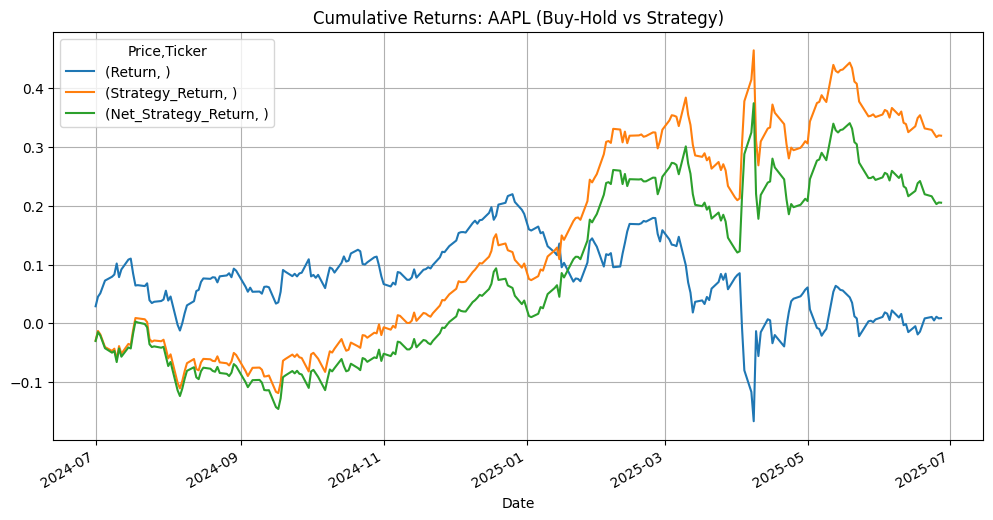


📊 Hypothesis Test (Mean Return ≠ 0):
t-statistic: 0.642, p-value: 0.52174
✅ Cannot reject the null — performance may be due to chance.

📊 Bootstrapping Sharpe Ratio:


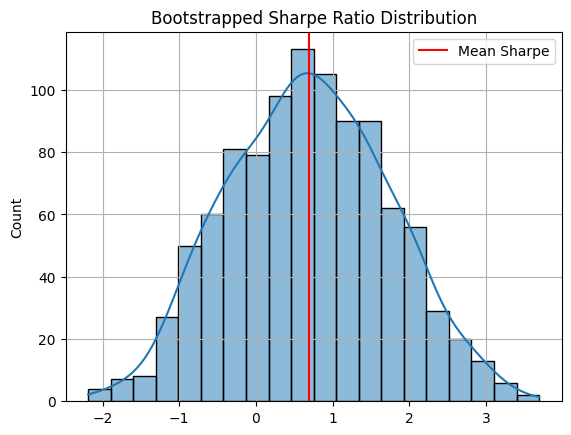

/tmp/ipython-input-18-701664927.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period)
[*********************100%***********************]  1 of 1 completed


Ticker: GOOG
Sharpe Ratio (Raw Strategy): 0.12
Sharpe Ratio (With Cost):    -0.25


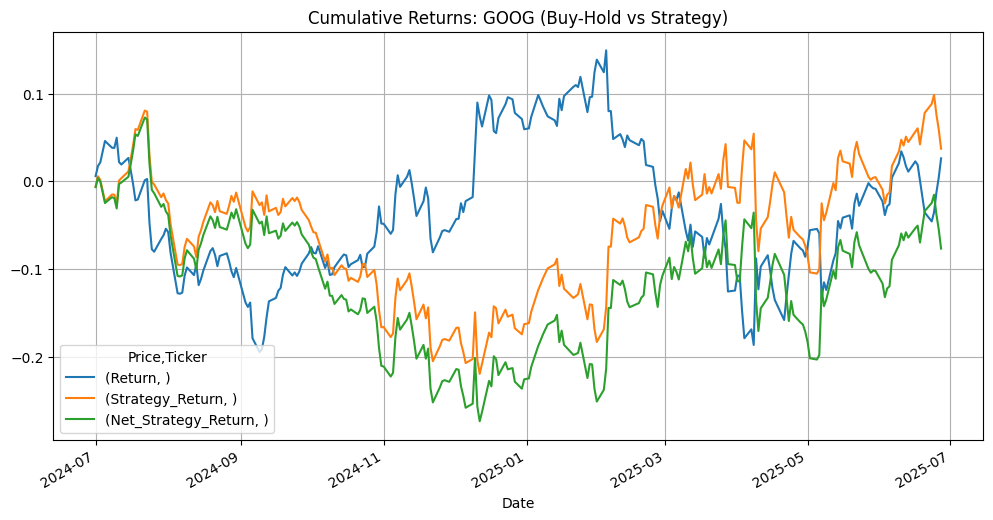


📊 Hypothesis Test (Mean Return ≠ 0):
t-statistic: -0.244, p-value: 0.80777
✅ Cannot reject the null — performance may be due to chance.

📊 Bootstrapping Sharpe Ratio:


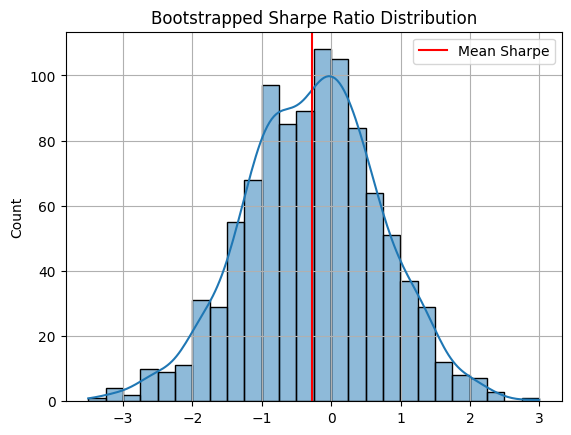

/tmp/ipython-input-18-701664927.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period)
[*********************100%***********************]  1 of 1 completed


Ticker: MSFT
Sharpe Ratio (Raw Strategy): 0.13
Sharpe Ratio (With Cost):    -0.32


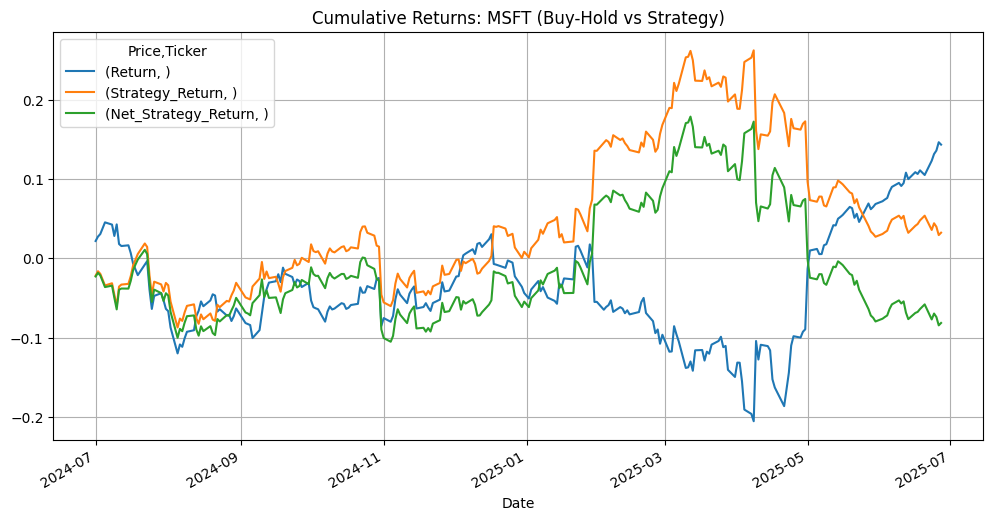


📊 Hypothesis Test (Mean Return ≠ 0):
t-statistic: -0.320, p-value: 0.74887
✅ Cannot reject the null — performance may be due to chance.

📊 Bootstrapping Sharpe Ratio:


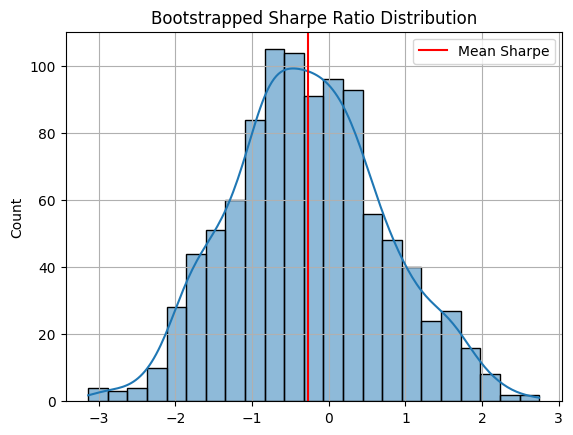

In [ ]:
tickers = ["AAPL", "GOOG", "MSFT"]

for ticker in tickers:
    run_coin_flip_strategy(ticker, cost=0.001)


In [ ]:
from scipy import stats

def hypothesis_test(strategy_returns, alpha=0.05):
    """Perform one-sample t-test to see if mean return is statistically different from 0."""
    t_stat, p_value = stats.ttest_1samp(strategy_returns.dropna(), 0)
    print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.5f}")

    if p_value < alpha:
        print("❗ Reject the null hypothesis — strategy is statistically significant.")
    else:
        print("✅ Cannot reject the null — performance may be due to chance.")

def bootstrap_sharpe(returns, n_iterations=1000):
    """Estimate Sharpe ratio distribution by bootstrapping."""
    sharpe_samples = []
    for _ in range(n_iterations):
        sample = returns.sample(frac=1, replace=True)
        s = sample.mean() / sample.std() * np.sqrt(252)
        sharpe_samples.append(s)
    return sharpe_samples
